# Writing the pair momentum distribution in terms of single-nucleon momentum distributions

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ July 4, 2023

We compute pair momentum distributions in terms of single-nucleon momentum distributions.

_Last update:_ August 29, 2023

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial.legendre import leggauss
from scipy.interpolate import InterpolatedUnivariateSpline, RectBivariateSpline

In [2]:
# Imports from scripts
from scripts.figures import set_rc_parameters, label_lambda, label_nucleus
from scripts.integration import gaussian_quadrature_mesh

from test_momentum_distribution_script import load_momentum_distribution
from test_pmd_script import load_pmd

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
vmc_directory = '../data/vmc/momentum_distributions/'

## Testing

$$
n_{pn}(q, Q) \approx \frac{1}{2} (4\pi)^2 \int_{-1}^1 \frac{dx}{2}\,
    n_n(\lvert \frac{\mathbf{Q}}{2}-\mathbf{q} \rvert)\,
    n_p(\lvert \frac{\mathbf{Q}}{2}+\mathbf{q} \rvert)
$$
where</br>
$$
\lvert \frac{\mathbf{Q}}{2}\pm\mathbf{q} \rvert = \sqrt{\frac{Q^2}{4}+q^2 \pm qQx}
$$

In [5]:
# n(q, Q) = < Phi | dU a^t a^t a a a^t a^t a a a^t a^t a a dU^t | \Phi >
# dU(k,q) dU^\dagger(q,k') psi(k1) psi(k2) psi(k3) psi(k4)
# where k_i = Q/2+-k


# a^t a^t a a = a^t a + 1/2 a^t a a^t a
# = ... + 1/2 U a^t a U^t U a^t a U^t
# = ... + 1/2 < Phi | U a^t a U^t U a^t a U^t | Phi >
# = ... + 1/2 SUM < Phi | U a^t a U^t | Psi > < Psi | U a^t a U^t | Phi >
# \approx ... + 1/2 < Phi | U a^t a U^t | Phi > < Phi | U a^t a U^t | Phi >

In [6]:
def n_pair(
        nucleus_name, pair, kvnn, lamb, Q_max=6.0, ntot_Q=60,
        print_normalization=False
):
    """Pair momentum distribution in terms of single-nucleon momentum
    distributions.
    """
    
    if pair == 'pp':
        nucleon = 'proton'
        nucleonp = 'proton'
    elif pair == 'nn':
        nucleon = 'neutron'
        nucleonp = 'neutron'
    elif pair == 'pn':
        nucleon = 'proton'
        nucleonp = 'neutron'
    elif pair == 'np':
        nucleon = 'neutron'
        nucleonp = 'proton'

    # C.o.M. momenta
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Load single-nucleon momentum distributions
    (q_array, q_weights, n_tau_array, _, _, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
    )
    (q_array, q_weights, n_taup_array, _, _, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleonp, kvnn, lamb)
    )

    # Interpolate single-nucleon momentum distributions
    n_tau_func = InterpolatedUnivariateSpline(q_array, n_tau_array)
    n_taup_func = InterpolatedUnivariateSpline(q_array, n_taup_array)
    
    # Integration for angle between q_vector and Q_vector
    x_array, x_weights = leggauss(29)
    
    # Get 3-D meshgrid and integrate evaluate n(q_vector, Q_vector)
    q_grid, Q_grid, x_grid = np.meshgrid(q_array, Q_array, x_array,
                                         indexing='ij')
    _, _, dx_grid = np.meshgrid(q_array, Q_array, x_weights, indexing='ij')
    
    # |Q/2+q|
    q1_grid = np.sqrt(Q_grid ** 2 / 4 + q_grid ** 2 + q_grid * Q_grid * x_grid)
    q2_grid = np.sqrt(Q_grid ** 2 / 4 + q_grid ** 2 - q_grid * Q_grid * x_grid)
    
    # n^\tau(|Q/2+q|) * n^\tau'(|Q/2-q|)
    integrand_x = 1/2 * n_tau_func(q1_grid) * n_taup_func(q2_grid)
    
    # Average over x
    n_grid = 4 * np.pi * np.sum(integrand_x * dx_grid, axis=-1) / 2
    
    # Append q=0 term?
    if pair == 'pp' or pair == 'nn':
        # TO-DO!
        pass

    if print_normalization:
        
        q_grid, Q_grid = np.meshgrid(q_array, Q_array, indexing='ij')
        dq_grid, dQ_grid = np.meshgrid(q_weights, Q_weights, indexing='ij')
        jacobian = 4 * np.pi * q_grid ** 2 * dq_grid * Q_grid ** 2 * dQ_grid
        
        normalization = np.sum(np.sum(jacobian * n_grid, axis=-1), axis=-1)
        print(f"Normalization = {normalization:.5f}.")
    
    return q_array, q_weights, Q_array, Q_weights, n_grid

In [7]:
def n_pair_contributions(
        nucleus_name, pair, kvnn, lamb, Q_max=6.0, ntot_Q=60,
        print_normalization=False
):
    """Contributions to the above function."""
    
    if pair == 'pp':
        nucleon = 'proton'
        nucleonp = 'proton'
    elif pair == 'nn':
        nucleon = 'neutron'
        nucleonp = 'neutron'
    elif pair == 'pn':
        nucleon = 'proton'
        nucleonp = 'neutron'
    elif pair == 'np':
        nucleon = 'neutron'
        nucleonp = 'proton'

    # C.o.M. momenta
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Load single-nucleon momentum distributions
    (q_array, q_weights, n_tau_array, _, n_tau_I_array, n_tau_deltaU_array, _,
     n_tau_deltaU2_array, _) = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
    )
    (q_array, q_weights, n_taup_array, _, n_taup_I_array, n_taup_deltaU_array,
     _, n_taup_deltaU2_array, _) = (
        load_momentum_distribution(nucleus_name, nucleonp, kvnn, lamb)
    )

    # Interpolate first
    n_tau_func = InterpolatedUnivariateSpline(q_array, n_tau_array)
    n_tau_I_func = InterpolatedUnivariateSpline(q_array, n_tau_I_array)
    n_tau_deltaU_func = InterpolatedUnivariateSpline(q_array,
                                                     n_tau_deltaU_array)
    n_tau_deltaU2_func = InterpolatedUnivariateSpline(q_array,
                                                      n_tau_deltaU2_array)
    # Same for tau'
    n_taup_func = InterpolatedUnivariateSpline(q_array, n_taup_array)
    n_taup_I_func = InterpolatedUnivariateSpline(q_array, n_taup_I_array)
    n_taup_deltaU_func = InterpolatedUnivariateSpline(q_array,
                                                      n_taup_deltaU_array)
    n_taup_deltaU2_func = InterpolatedUnivariateSpline(q_array,
                                                       n_taup_deltaU2_array)
    
    # Integration for angle between q_vector and Q_vector
    x_array, x_weights = leggauss(29)
    # Get 3-D meshgrid and integrate evaluate n(q_vector, Q_vector)
    q_grid, Q_grid, x_grid = np.meshgrid(q_array, Q_array, x_array,
                                         indexing='ij')
    _, _, dx_grid = np.meshgrid(q_array, Q_array, x_weights, indexing='ij')
    
    # |Q/2+q|
    q1_grid = np.sqrt(Q_grid ** 2 / 4 + q_grid ** 2 + q_grid * Q_grid * x_grid)
    q2_grid = np.sqrt(Q_grid ** 2 / 4 + q_grid ** 2 - q_grid * Q_grid * x_grid)
    
    # Average over x keeping each contribution:
    
    # Full result
    n_integrand = 1/2 * n_tau_func(q1_grid) * n_taup_func(q2_grid)
    n_grid = 4 * np.pi * np.sum(n_integrand * dx_grid, axis=-1) / 2
    
    # I
    n_I_integrand = 1/2 * n_tau_I_func(q1_grid) * n_taup_I_func(q2_grid)
    n_I_grid = 4 * np.pi * np.sum(n_I_integrand * dx_grid, axis=-1) / 2
    
    # 2 (\delta U + \delta U^\dagger)
    n_delU_integrand = 1/2 * (
        n_tau_deltaU_func(q1_grid) * n_taup_I_func(q2_grid)
        + n_tau_I_func(q1_grid) * n_taup_deltaU_func(q2_grid)
    )
    n_delU_grid = 4 * np.pi * np.sum(n_delU_integrand * dx_grid, axis=-1) / 2
    
    # 2 \delta U \delta U^\dagger
    n_delUdelUdag_integrand = 1/2 * (
        n_tau_deltaU2_func(q1_grid) * n_taup_I_func(q2_grid)
        + n_tau_I_func(q1_grid) * n_taup_deltaU2_func(q2_grid)
    )
    n_delUdelUdag_grid = 4 * np.pi * np.sum(n_delUdelUdag_integrand * dx_grid,
                                            axis=-1) / 2
    
    # (\delta U + \delta U^\dagger)^2
    n_delU2_integrand = 1/2 * (n_tau_deltaU_func(q1_grid)
                               * n_taup_deltaU_func(q2_grid))
    n_delU2_grid = 4 * np.pi * np.sum(n_delU2_integrand * dx_grid, axis=-1) / 2
    
    # (\delta U + \delta U^\dagger) \delta U \delta U^\dagger + ...
    n_delUdelUdagdelU2_integrand = 1/2 * (
        n_tau_deltaU_func(q1_grid) * n_taup_deltaU2_func(q2_grid)
        + n_tau_deltaU2_func(q1_grid) * n_taup_deltaU_func(q2_grid)
    )
    n_delUdelUdagdelU2_grid = 4 * np.pi * np.sum(
        n_delUdelUdagdelU2_integrand * dx_grid, axis=-1) / 2
    
    # (\delta U \delta U^\dagger)^2
    n_delUdelUdag2_integrand = 1/2 * (n_tau_deltaU2_func(q1_grid)
                                      * n_taup_deltaU2_func(q2_grid))
    n_delUdelUdag2_grid = 4 * np.pi * np.sum(n_delUdelUdag2_integrand * dx_grid,
                                             axis=-1) / 2

    if print_normalization:

        q_grid, Q_grid = np.meshgrid(q_array, Q_array, indexing='ij')
        dq_grid, dQ_grid = np.meshgrid(q_weights, Q_weights, indexing='ij')
        jacobian = 4 * np.pi * q_grid ** 2 * dq_grid * Q_grid ** 2 * dQ_grid
        
        # Full result
        total_norm = np.sum(np.sum(jacobian * n_grid, axis=-1), axis=-1)
        print(f"Total normalization = {total_norm:.5f}.")
        
        # I
        I_norm = np.sum(np.sum(jacobian * n_I_grid, axis=-1), axis=-1)
        print(f"I normalization = {I_norm:.5f}.")
        
        # 2 (\delta U + \delta U^\dagger)
        delU_norm = np.sum(np.sum(jacobian * n_delU_grid, axis=-1), axis=-1)
        print("2(\delta U + \delta U^\dagger) normalization = "
              f"{delU_norm:.5f}.")
        
        # 2 \delta U \delta U^\dagger
        delUdelUdag_norm = np.sum(
            np.sum(jacobian * n_delUdelUdag_grid, axis=-1), axis=-1)
        print("2(\delta U \delta U^\dagger) normalization = "
              f"{delUdelUdag_norm:.5f}.")
        
        # (\delta U + \delta U^\dagger)^2
        delU2_norm = np.sum(
            np.sum(jacobian * n_delU2_grid, axis=-1), axis=-1)
        print("(\delta U + \delta U^\dagger)^2 normalization = "
              f"{delU2_norm:.5f}.")

        # (\delta U + \delta U^\dagger) \delta U \delta U^\dagger + ...
        delUdelUdagdelU2_norm = np.sum(
            np.sum(jacobian * n_delUdelUdagdelU2_grid, axis=-1), axis=-1)
        print("(\delta U + \delta U^\dagger) \delta U \delta U^\dagger + ... "
              f" normalization = {delUdelUdagdelU2_norm:.5f}.")
        
        # (\delta U \delta U^\dagger)^2
        delUdelUdag2_norm = np.sum(
            np.sum(jacobian * n_delUdelUdag2_grid, axis=-1), axis=-1)
        print("(\delta U \delta U^\dagger)^2 normalization = "
              f"{delUdelUdag2_norm:.5f}.")
        
    return (
        q_array, q_weights, Q_array, Q_weights, n_grid, n_I_grid, n_delU_grid,
        n_delUdelUdag_grid, n_delU2_grid, n_delUdelUdagdelU2_grid,
        n_delUdelUdag2_grid
    )

In [8]:
def pair_momentum_distribution_q(
        nucleus_name, pair, kvnn, lamb, x_limits=(0.0,6.0), y_limits=(1e-4,1e4),
        y_scale='log', show_vmc=False
):
    """Plot a pair momentum distribution w.r.t. q."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_pair.txt"
        data = np.loadtxt(vmc_directory + file_name)
        q_array_vmc = data[:,0]
        if pair == 'pp':
            n_array_vmc = data[:,3]
            n_errors_vmc = data[:,4]
        else:
            n_array_vmc = data[:,1]
            n_errors_vmc = data[:,2]

        if y_scale == 'linear':
            
            ax.errorbar(
                q_array_vmc, n_array_vmc * q_array_vmc ** 2 , yerr=n_errors_vmc,
                color='black', label='VMC', linestyle='', marker='.', zorder=3
            )
            
        else:
            
            ax.errorbar(
                q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                label='VMC', linestyle='', marker='.', zorder=3
            )
            
    # Load data from file
    (q_array, q_weights, Q_array, Q_weights, n_pair_grid, _, _, _, _, _, _) = (
        load_pmd(nucleus_name, pair, kvnn, lamb))
    # Integrate out Q dependence
    _, Q_grid = np.meshgrid(q_array, Q_array, indexing='ij')
    _, dQ_grid = np.meshgrid(q_weights, Q_weights, indexing='ij')
    jacobian = 4 * np.pi * Q_grid ** 2 * dQ_grid
    n_pair_array = np.sum(jacobian * n_pair_grid, axis=-1)
    
    # Get pair from single-nucleon distributions
    q_snmd_array, q_snmd_weights, Q_snmd_array, Q_snmd_weights, n_snmd_grid = (
        n_pair(nucleus_name, pair, kvnn, lamb, print_normalization=True))
    # Integrate out Q dependence
    _, Q_snmd_grid = np.meshgrid(q_snmd_array, Q_snmd_array, indexing='ij')
    _, dQ_snmd_grid = np.meshgrid(q_snmd_weights, Q_snmd_weights, indexing='ij')
    jacobian = 4 * np.pi * Q_snmd_grid ** 2 * dQ_snmd_grid
    n_snmd_array = np.sum(jacobian * n_snmd_grid, axis=-1)

    # Multiply by factor (2\pi)^3 / (4\pi) to compare to VMC data
    factor = (2*np.pi) ** 3 / (4*np.pi)
    # Factor of 2 for combination of pn + np
    if pair == 'pn' or pair == 'np':
        n_pair_array *= 2 * factor
        n_snmd_array *= 2 * factor
    else:
        n_pair_array *= factor
        n_snmd_array *= factor

    # Add to plot
    pair_label = r"$n(q)$"
    snmd_label = r"$\int \frac{dx}{2} \, n(q_1) \, n(q_2)$"
    if y_scale == 'linear':
        
        ax.plot(q_array, n_pair_array * q_array ** 2, label=pair_label,
                linewidth=2.0, zorder=1)
        ax.plot(q_snmd_array, n_snmd_array * q_snmd_array ** 2,
                label=snmd_label, linewidth=2.0, zorder=2)

    else:
        
        ax.plot(q_array, n_pair_array, label=pair_label, linewidth=2.0,
                zorder=1)
        ax.plot(q_snmd_array, n_snmd_array, label=snmd_label, linewidth=2.0,
                zorder=2)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear':
        ylabel = rf"$q^2 n_{{{pair}}}(q)$ [fm]"
    elif y_scale == 'log':
        ylabel = rf"$n_{{{pair}}}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=12, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    plt.show()

In [9]:
def pair_momentum_distribution_Q(
        nucleus_name, pair, kvnn, lamb, x_limits=(0.0,5.0), y_limits=(1e-1,1e4),
        y_scale='log', show_vmc=False
):
    """Plot a pair momentum distribution w.r.t. Q."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_pair_Q.txt"
        data = np.loadtxt(vmc_directory + file_name)
        Q_array_vmc = data[:,0]
        if pair == 'pp':
            n_array_vmc = data[:,3]
            n_errors_vmc = data[:,4]
        else:
            n_array_vmc = data[:,1]
            n_errors_vmc = data[:,2]

        if y_scale == 'linear':
            
            ax.errorbar(
                Q_array_vmc, n_array_vmc * Q_array_vmc ** 2 , yerr=n_errors_vmc,
                color='black', label='VMC', linestyle='', marker='.', zorder=3
            )
            
        else:
            
            ax.errorbar(
                Q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                label='VMC', linestyle='', marker='.', zorder=3
            )
            
    # Load data from file
    (q_array, q_weights, Q_array, Q_weights, n_pair_grid, _, _, _, _, _, _) = (
        load_pmd(nucleus_name, pair, kvnn, lamb))
    # Integrate out Q dependence
    q_grid, _ = np.meshgrid(q_array, Q_array, indexing='ij')
    dq_grid, _ = np.meshgrid(q_weights, Q_weights, indexing='ij')
    jacobian = q_grid ** 2 * dq_grid
    n_pair_array = np.sum(jacobian * n_pair_grid, axis=0)
    
    # Get pair from single-nucleon distributions
    q_snmd_array, q_snmd_weights, Q_snmd_array, Q_snmd_weights, n_snmd_grid = (
        n_pair(nucleus_name, pair, kvnn, lamb, print_normalization=True))
    # Integrate out Q dependence
    q_snmd_grid, _ = np.meshgrid(q_snmd_array, Q_snmd_array, indexing='ij')
    dq_snmd_grid, _ = np.meshgrid(q_snmd_weights, Q_snmd_weights, indexing='ij')
    jacobian = q_snmd_grid ** 2 * dq_snmd_grid
    n_snmd_array = np.sum(jacobian * n_snmd_grid, axis=0)

    # Multiply by factor (2\pi)^3 to compare to VMC data
    factor = (2*np.pi) ** 3
    # Factor of 2 for combination of pn + np
    if pair == 'pn' or pair == 'np':
        n_pair_array *= 2 * factor
        n_snmd_array *= 2 * factor
    else:
        n_pair_array *= factor
        n_snmd_array *= factor

    # Add to plot
    pair_label = r"$n(Q)$"
    snmd_label = r"$\int \frac{dx}{2} \, n(q_1) \, n(q_2)$"
    if y_scale == 'linear':
        
        ax.plot(Q_array, n_pair_array * Q_array ** 2, label=pair_label,
                linewidth=2.0, zorder=1)
        ax.plot(Q_snmd_array, n_snmd_array * Q_snmd_array ** 2,
                label=snmd_label, linewidth=2.0, zorder=2)

    else:
        
        ax.plot(Q_array, n_pair_array, label=pair_label, linewidth=2.0,
                zorder=1)
        ax.plot(Q_snmd_array, n_snmd_array, label=snmd_label, linewidth=2.0,
                zorder=2)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$Q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear':
        ylabel = rf"$Q^2 n_{{{pair}}}(Q)$ [fm]"
    elif y_scale == 'log':
        ylabel = rf"$n_{{{pair}}}(Q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=12, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    plt.show()
    
    return Q_snmd_array, n_snmd_array

In [10]:
def pair_momentum_distribution_contributions_q(
        nucleus_name, pair, kvnn, lamb, x_limits=(0.0,6.0), y_limits=(1e-4,1e4),
        show_vmc=False
):
    """Plot a pair momentum distribution w.r.t. q."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    ax.set_yscale('log')
        
    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_pair.txt"
        data = np.loadtxt(vmc_directory + file_name)
        q_array_vmc = data[:,0]
        if pair == 'pp':
            n_array_vmc = data[:,3]
            n_errors_vmc = data[:,4]
        else:
            n_array_vmc = data[:,1]
            n_errors_vmc = data[:,2]

        ax.errorbar(q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                    label='VMC', linestyle='', marker='.', zorder=8)
            
    # Get pair from single-nucleon distributions
    (q_array, q_weights, Q_array, Q_weights, n_grid, n_I_grid, n_delU_grid,
     n_delUdelUdag_grid, n_delU2_grid, n_delUdelUdagdelU2_grid, 
     n_delUdelUdag2_grid) = n_pair_contributions(nucleus_name, pair, kvnn, lamb,
                                                 print_normalization=True)
    # Integrate out Q dependence
    _, Q_grid = np.meshgrid(q_array, Q_array, indexing='ij')
    _, dQ_grid = np.meshgrid(q_weights, Q_weights, indexing='ij')
    jacobian = 4 * np.pi * Q_grid ** 2 * dQ_grid
    n_array = np.sum(jacobian * n_grid, axis=-1)
    n_I_array = np.sum(jacobian * n_I_grid, axis=-1)
    n_delU_array = np.sum(jacobian * n_delU_grid, axis=-1)
    n_delUdelUdag_array = np.sum(jacobian * n_delUdelUdag_grid, axis=-1)
    n_delU2_array = np.sum(jacobian * n_delU2_grid, axis=-1)
    n_delUdelUdagdelU2_array = np.sum(jacobian * n_delUdelUdagdelU2_grid,
                                      axis=-1)
    n_delUdelUdag2_array = np.sum(jacobian * n_delUdelUdag2_grid, axis=-1)

    # Multiply by factor (2\pi)^3 / (4\pi) to compare to VMC data
    factor = (2*np.pi) ** 3 / (4*np.pi)
    # Factor of 2 for combination of pn + np
    if pair == 'pn' or pair == 'np':
        n_array *= 2 * factor
        n_I_array *= 2 * factor
        n_delU_array *= 2 * factor
        n_delUdelUdag_array *= 2 * factor
        n_delU2_array *= 2 * factor 
        n_delUdelUdagdelU2_array *= 2 * factor
        n_delUdelUdag2_array *= 2 * factor
    else:
        n_array *= factor
        n_I_array *= factor
        n_delU_array *= factor
        n_delUdelUdag_array *= factor
        n_delU2_array *= factor 
        n_delUdelUdagdelU2_array *= factor
        n_delUdelUdag2_array *= factor

    # Add to plot
    ax.plot(q_array, n_array, label='Total', linewidth=2.0, zorder=1)
    ax.plot(q_array, n_I_array, label=r'$I \times I$', linewidth=2.0, zorder=2)
    ax.plot(
        q_array, np.abs(n_delU_array),
        label=r'$|\delta U + \delta U^\dagger| \times I$', linewidth=2.0,
        zorder=3
    )
    ax.plot(
        q_array, n_delUdelUdag_array,
        label=r'$\delta U \delta U^\dagger \times I$', linewidth=2.0, zorder=4
    )
    ax.plot(
        q_array, np.abs(n_delU2_array),
        label=r'$|(\delta U + \delta U^\dagger) \times (\delta U + \delta U^\dagger)|$',
        linewidth=2.0, zorder=5
    )
    ax.plot(
        q_array, np.abs(n_delUdelUdagdelU2_array),
        label=r'$|(\delta U+\delta U^\dagger) \times \delta U \delta U^\dagger|$',
        linewidth=2.0, zorder=6
    )
    ax.plot(
        q_array, n_delUdelUdag2_array,
        label=r'$(\delta U \delta U^\dagger) \times (\delta U \delta U^\dagger)$',
        linewidth=2.0, zorder=7
    )

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(rf"$n_{{{pair}}}(q)$ [fm" + r'$^3$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=8, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='lower left',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    plt.show()

In [11]:
def pair_momentum_distribution_contributions_Q(
        nucleus_name, pair, kvnn, lamb, x_limits=(0.0,5.0), y_limits=(1e-1,1e4),
        show_vmc=False
):
    """Plot a pair momentum distribution w.r.t. Q."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    ax.set_yscale('log')

    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_pair_Q.txt"
        data = np.loadtxt(vmc_directory + file_name)
        Q_array_vmc = data[:,0]
        if pair == 'pp':
            n_array_vmc = data[:,3]
            n_errors_vmc = data[:,4]
        else:
            n_array_vmc = data[:,1]
            n_errors_vmc = data[:,2]

        ax.errorbar(Q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                    label='VMC', linestyle='', marker='.', zorder=8)
            
    # Get pair from single-nucleon distributions
    (q_array, q_weights, Q_array, Q_weights, n_grid, n_I_grid, n_delU_grid,
     n_delUdelUdag_grid, n_delU2_grid, n_delUdelUdagdelU2_grid, 
     n_delUdelUdag2_grid) = n_pair_contributions(nucleus_name, pair, kvnn, lamb,
                                                 print_normalization=True)
    # Integrate out Q dependence
    q_grid, _ = np.meshgrid(q_array, Q_array, indexing='ij')
    dq_grid, _ = np.meshgrid(q_weights, Q_weights, indexing='ij')
    jacobian = q_grid ** 2 * dq_grid
    n_array = np.sum(jacobian * n_grid, axis=0)
    n_I_array = np.sum(jacobian * n_I_grid, axis=0)
    n_delU_array = np.sum(jacobian * n_delU_grid, axis=0)
    n_delUdelUdag_array = np.sum(jacobian * n_delUdelUdag_grid, axis=0)
    n_delU2_array = np.sum(jacobian * n_delU2_grid, axis=0)
    n_delUdelUdagdelU2_array = np.sum(jacobian * n_delUdelUdagdelU2_grid,
                                      axis=0)
    n_delUdelUdag2_array = np.sum(jacobian * n_delUdelUdag2_grid, axis=0)

    # Multiply by factor (2\pi)^3 to compare to VMC data
    factor = (2*np.pi) ** 3
    # Factor of 2 for combination of pn + np
    if pair == 'pn' or pair == 'np':
        n_array *= 2 * factor
        n_I_array *= 2 * factor
        n_delU_array *= 2 * factor
        n_delUdelUdag_array *= 2 * factor
        n_delU2_array *= 2 * factor 
        n_delUdelUdagdelU2_array *= 2 * factor
        n_delUdelUdag2_array *= 2 * factor
    else:
        n_array *= factor
        n_I_array *= factor
        n_delU_array *= factor
        n_delUdelUdag_array *= factor
        n_delU2_array *= factor 
        n_delUdelUdagdelU2_array *= factor
        n_delUdelUdag2_array *= factor

    # Add to plot
    ax.plot(Q_array, n_array, label='Total', linewidth=2.0, zorder=1)
    ax.plot(Q_array, n_I_array, label=r'$I \times I$', linewidth=2.0, zorder=2)
    ax.plot(
        Q_array, np.abs(n_delU_array),
        label=r'$|\delta U + \delta U^\dagger| \times I$', linewidth=2.0,
        zorder=3
    )
    ax.plot(
        Q_array, n_delUdelUdag_array,
        label=r'$\delta U \delta U^\dagger \times I$', linewidth=2.0, zorder=4
    )
    ax.plot(
        Q_array, np.abs(n_delU2_array),
        label=r'$|(\delta U + \delta U^\dagger) \times (\delta U + \delta U^\dagger)|$',
        linewidth=2.0, zorder=5
    )
    ax.plot(
        Q_array, np.abs(n_delUdelUdagdelU2_array),
        label=r'$|(\delta U+\delta U^\dagger) \times \delta U \delta U^\dagger|$',
        linewidth=2.0, zorder=6
    )
    ax.plot(
        Q_array, n_delUdelUdag2_array,
        label=r'$(\delta U \delta U^\dagger) \times (\delta U \delta U^\dagger)$',
        linewidth=2.0, zorder=7
    )

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$Q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(rf"$n_{{{pair}}}(Q)$ [fm" + r'$^3$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=8, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='upper left',
                     prop=dict(size=16), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    plt.show()

In [12]:
def load_vmc_pair_qQ(nucleus_name, Q):
    """Gets the n(q,Q) VMC data."""
    
    q_size = len(np.arange(0.1, 6.1, 0.1)) + 1
    data = np.zeros((q_size, 5))
    
    directory = "../data/vmc/momentum_distributions/"
    file_name = f"{nucleus_name}_pair_qQ.txt"
    
    f = open(directory + file_name, 'r')
    
    i = 0
    flag = False
    for line in f:
        
        unit = line.strip().split()
        
        if len(unit) > 0 and unit[0] == "QQ(J)" and float(unit[2]) == Q:

            flag = True
            
        if flag:
            
            try:
                
                data[i, 0] = float(unit[0])
                data[i, 1] = float(unit[1])
                data[i, 2] = float(unit[2])
                data[i, 3] = float(unit[3])
                data[i, 4] = float(unit[4])
                
                i += 1
                
                if i > q_size:
                    
                    flag = False
                    
            except ValueError:
            
                pass
            
            except IndexError:
                
                pass
                    
    f.close()
    
    return data

In [13]:
def pair_momentum_distribution_q_Q(
        nucleus_name, pair, kvnn, lamb, Q_values, error_bars=False,
        x_limits=(0.0,5.0), y_limits=(1e-4,5e5), show_vmc=False
):
    """Plot a pair momentum distribution w.r.t. q and Q."""
    
    # Initialize figure
    plt.close('all')
    row_number, col_number = 2, int(len(Q_values)/2)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number, 4*row_number))

    # Get pair from single-nucleon distributions
    q_array, q_weights, Q_array, Q_weights, n_grid = (
        n_pair(nucleus_name, pair, kvnn, lamb, print_normalization=True))

    # Interpolate n(q, Q)
    n_func = RectBivariateSpline(q_array, Q_array, n_grid)
    
    # Evaluate on same q array but fixed Q points
    q_grid, Q_grid = np.meshgrid(q_array, Q_values, indexing='ij')

    # Multiply by factor of (2\pi)^6 / (4\pi) to compare to VMC
    # Factor of 2 for pn + np
    factor = (2*np.pi) ** 6 / (4*np.pi)
    if pair == 'pn':
        factor *= 2
    n_data = factor * n_func.ev(q_grid, Q_grid)
    
    iQ = 0
    for i in range(row_number):
        for j in range(col_number):

            Q = Q_values[iQ]
            
            # Compare to VMC calculation?
            if show_vmc:
        
                data = load_vmc_pair_qQ(nucleus_name, Q)
                q_array_vmc = data[:,0]
                if pair == 'pn': 
                    n_array_vmc = data[:,1]
                    n_errors_vmc = data[:,2]
                else:
                    n_array_vmc = data[:,3]
                    n_errors_vmc = data[:,4]

                axs[i, j].errorbar(
                    q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                    label=f'VMC {pair}', linestyle='', marker='.', zorder=2
                )

            # Add to plot
            n_array = n_data[:, iQ]
            
            if error_bars:
            
                axs[i, j].errorbar(
                    q_array, n_array, yerr=n_errors, color='blue',
                    label=f'SRG {pair}', linestyle='solid', linewidth=2.0,
                    zorder=1
                )
    
            else:
            
                axs[i, j].plot(q_array, n_array, label=f'SRG {pair}',
                               color='blue', linewidth=2.0, zorder=1)

            # Set axes limits
            axs[i, j].set_yscale('log')
            axs[i, j].set_xlim(x_limits)
            axs[i, j].set_ylim(y_limits)
            
            # Set axes labels
            if i > 0:
                axs[i, j].set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
            if j == 0:
                axs[i, j].set_ylabel(rf"$n(q,Q)$ [fm" + r'$^6$' + ']',
                                     fontsize=16)
                
            # Add Q label
            if i == 0:
                Q_label_location = "lower left"
            elif i == 1:
                Q_label_location = "upper right"
            axs[i, j].add_artist(
                AnchoredText(fr"$Q={Q}$" + " fm$^{-1}$", loc=Q_label_location,
                     prop=dict(size=18), frameon=False)
            )
                
            iQ += 1

    # Set legend
    axs[0, 0].legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    axs[0, 1].add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='upper right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label
    axs[0, 2].add_artist(
        AnchoredText(label_lambda(lamb), loc='upper right',
                     prop=dict(size=16), frameon=False)
    )
    
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.05, wspace=0.05)
    
    plt.show()

Normalization = 18.05230.


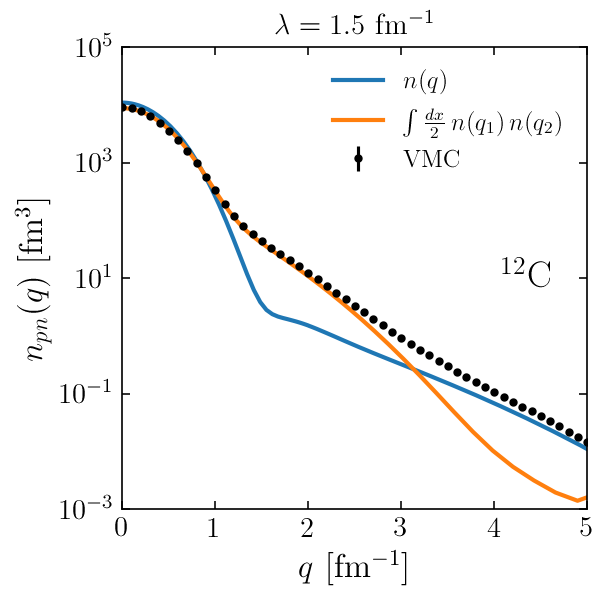

In [14]:
pair_momentum_distribution_q('C12', 'pn', 6, 1.5, x_limits=(0.0,5.0),
                             y_limits=(1e-3,1e5), show_vmc=True)

Normalization = 18.05230.


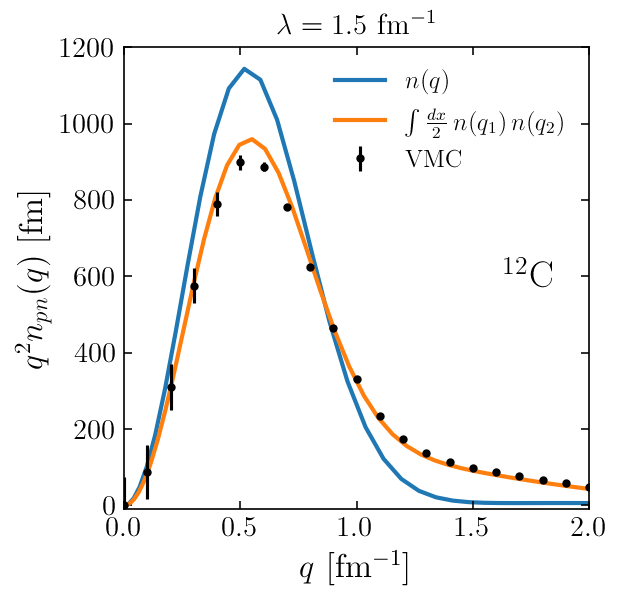

In [15]:
pair_momentum_distribution_q(
    'C12', 'pn', 6, 1.5, x_limits=(0.0,2.0), y_limits=(-10,1200),
    y_scale='linear', show_vmc=True
)

Normalization = 18.05230.


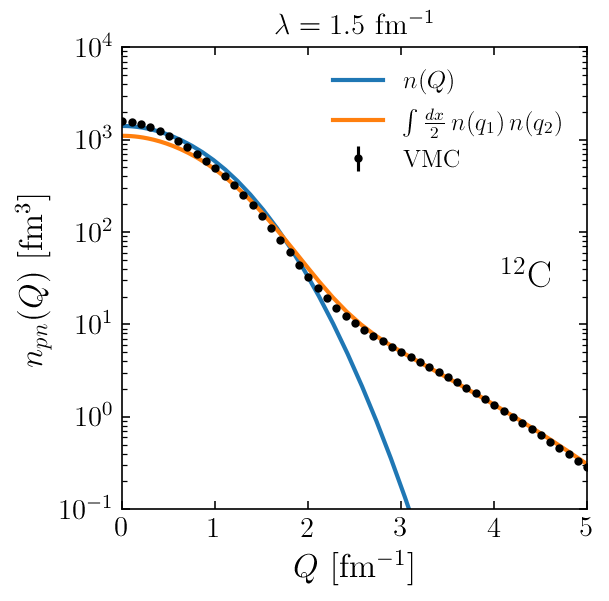

In [16]:
Q_array, n_array = pair_momentum_distribution_Q(
    'C12', 'pn', 6, 1.5, x_limits=(0.0,5.0), y_limits=(1e-1,1e4), show_vmc=True)

Normalization = 18.05230.


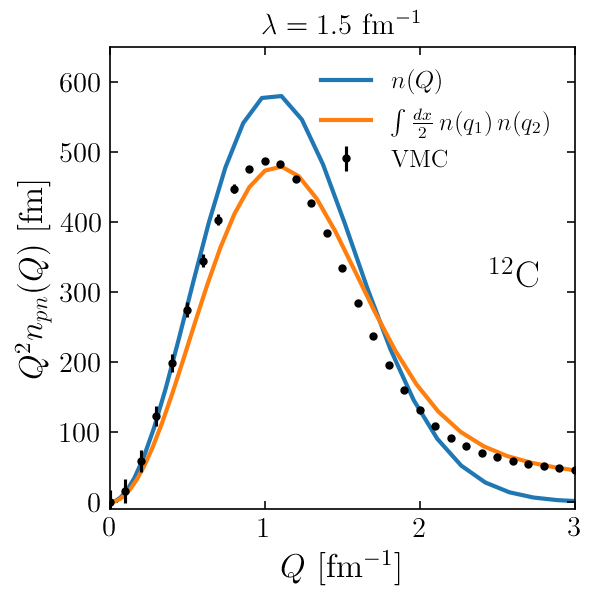

In [17]:
Q_array, n_array = pair_momentum_distribution_Q(
    'C12', 'pn', 6, 1.5, x_limits=(0.0,3.0), y_limits=(-10,650),
    y_scale='linear', show_vmc=True
)

Total normalization = 17.99491.
I normalization = 18.00004.
2(\delta U + \delta U^\dagger) normalization = -3.56462.
2(\delta U \delta U^\dagger) normalization = 3.57112.
(\delta U + \delta U^\dagger)^2 normalization = 0.17647.
(\delta U + \delta U^\dagger) \delta U \delta U^\dagger + ...  normalization = -0.35400.
(\delta U \delta U^\dagger)^2 normalization = 0.16590.


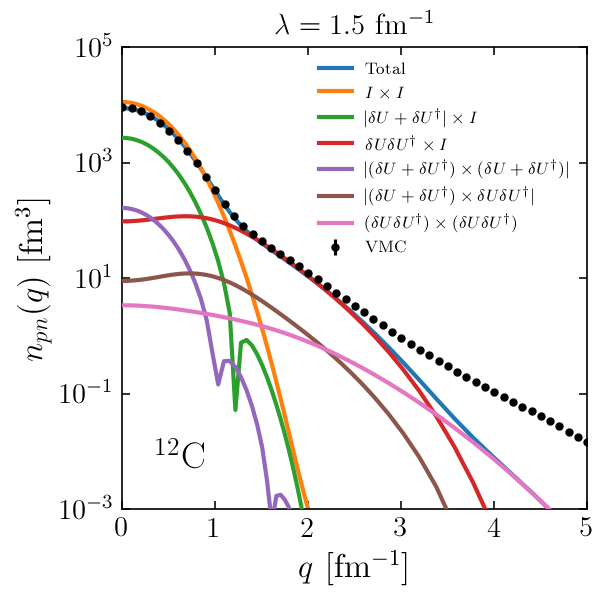

In [18]:
pair_momentum_distribution_contributions_q(
    'C12', 'pn', 6, 1.5, x_limits=(0.0,5.0), y_limits=(1e-3,1e5), show_vmc=True
)

Total normalization = 17.99491.
I normalization = 18.00004.
2(\delta U + \delta U^\dagger) normalization = -3.56462.
2(\delta U \delta U^\dagger) normalization = 3.57112.
(\delta U + \delta U^\dagger)^2 normalization = 0.17647.
(\delta U + \delta U^\dagger) \delta U \delta U^\dagger + ...  normalization = -0.35400.
(\delta U \delta U^\dagger)^2 normalization = 0.16590.


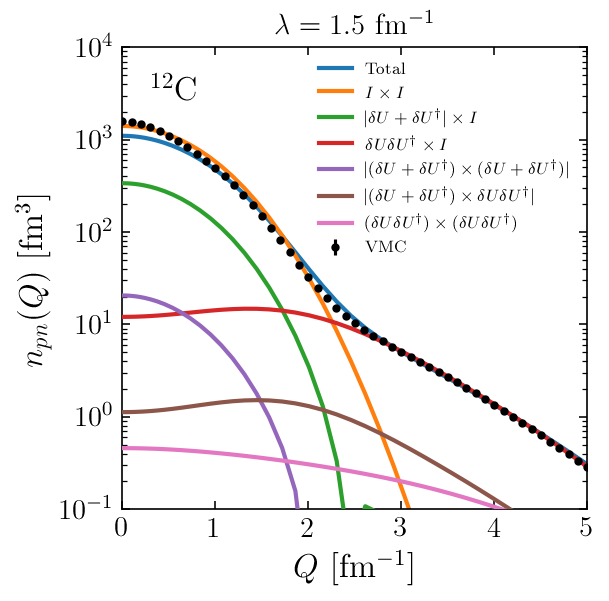

In [19]:
pair_momentum_distribution_contributions_Q(
    'C12', 'pn', 6, 1.5, x_limits=(0.0,5.0), y_limits=(1e-1,1e4),
    show_vmc=True
)

In [20]:
Q_low_array = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
Q_high_array = np.array([0.1, 0.5, 1.0, 2.0, 3.0, 4.0])

Normalization = 18.05230.


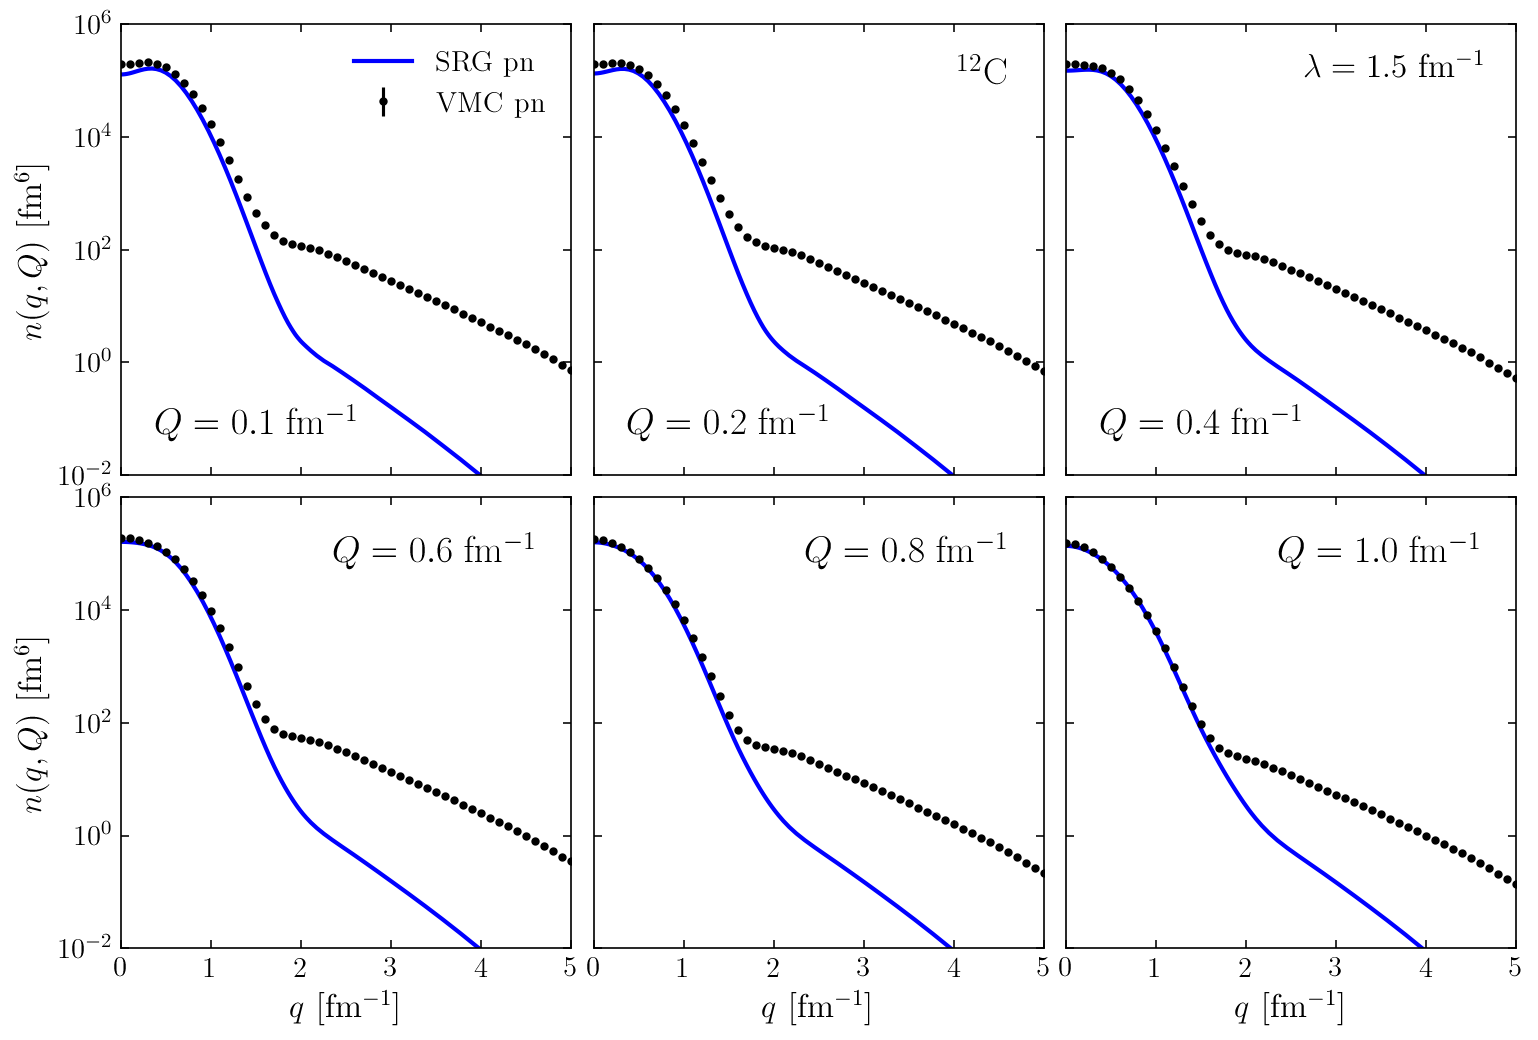

In [21]:
pair_momentum_distribution_q_Q('C12', 'pn', 6, 1.5, Q_low_array,
                               y_limits=(1e-2,1e6), show_vmc=True)

Normalization = 18.05230.


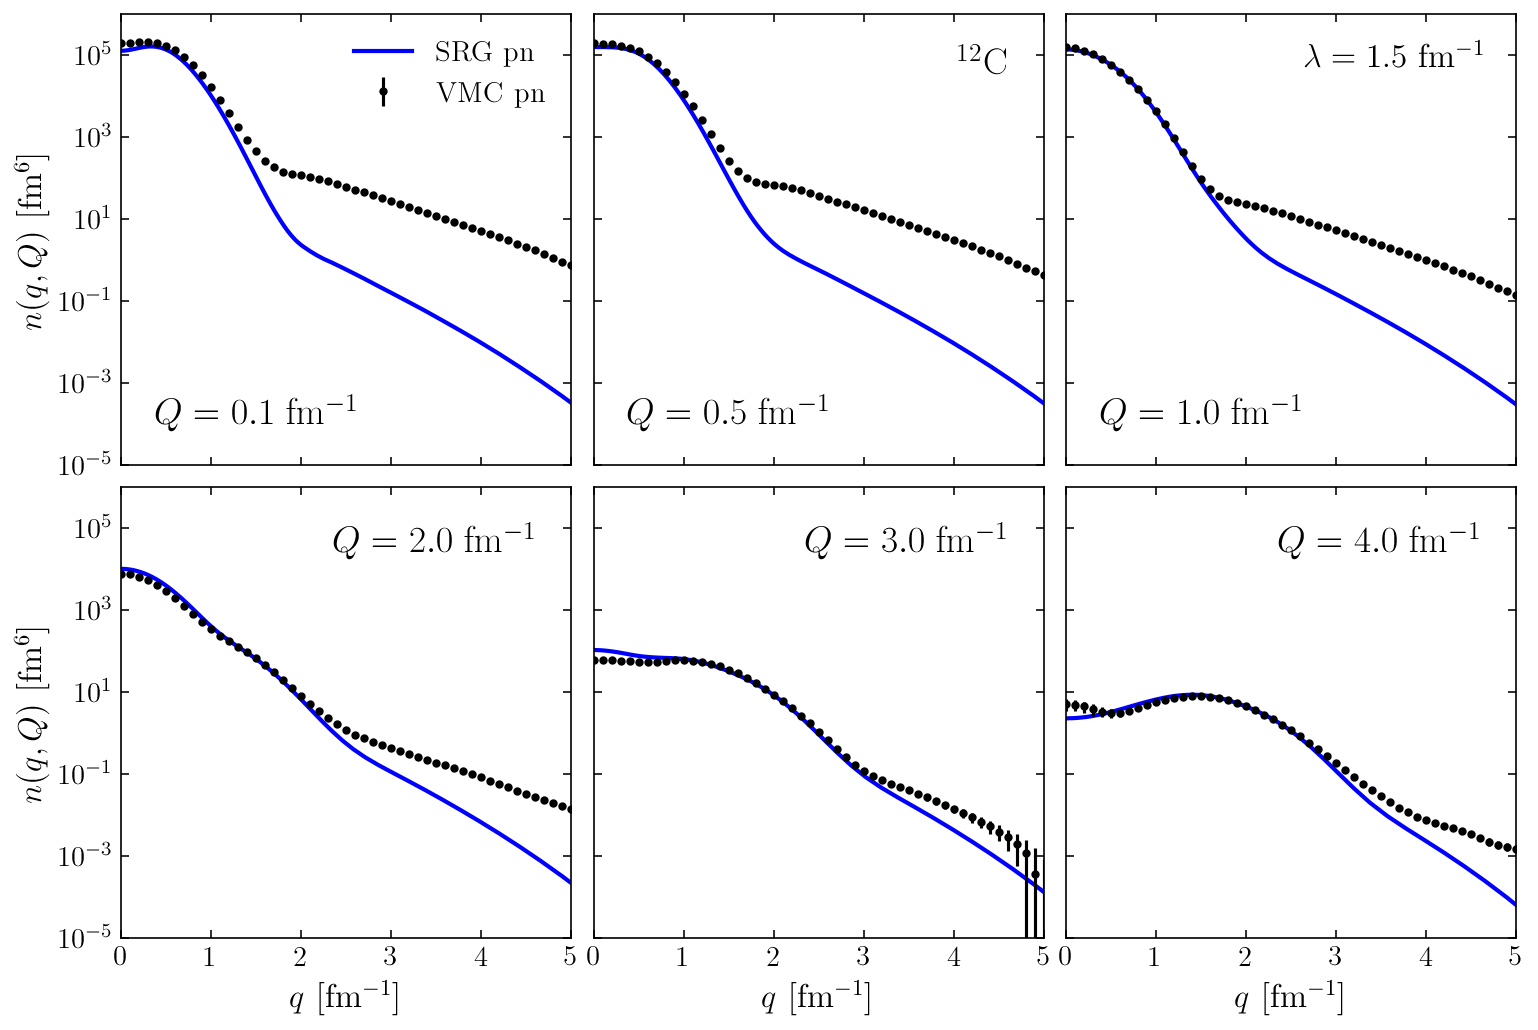

In [22]:
pair_momentum_distribution_q_Q('C12', 'pn', 6, 1.5, Q_high_array,
                               y_limits=(1e-5,1e6), show_vmc=True)

Normalization = 1.99806.


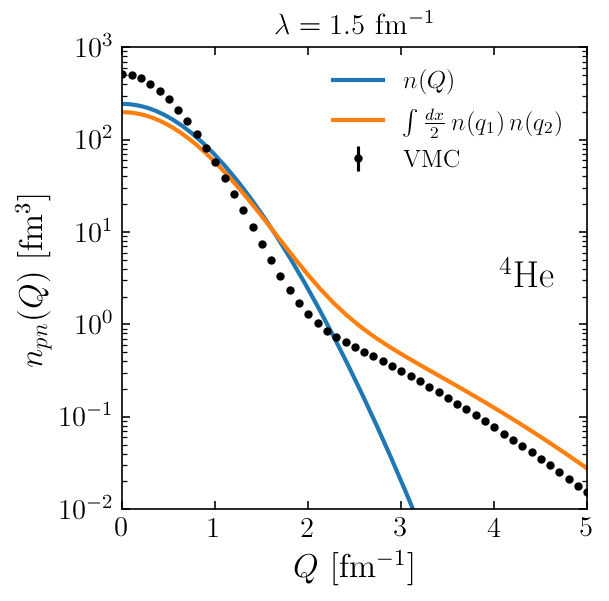

In [23]:
Q_array, n_array = pair_momentum_distribution_Q(
    'He4', 'pn', 6, 1.5, x_limits=(0.0,5.0), y_limits=(1e-2,1e3), show_vmc=True)

Normalization = 1.99806.


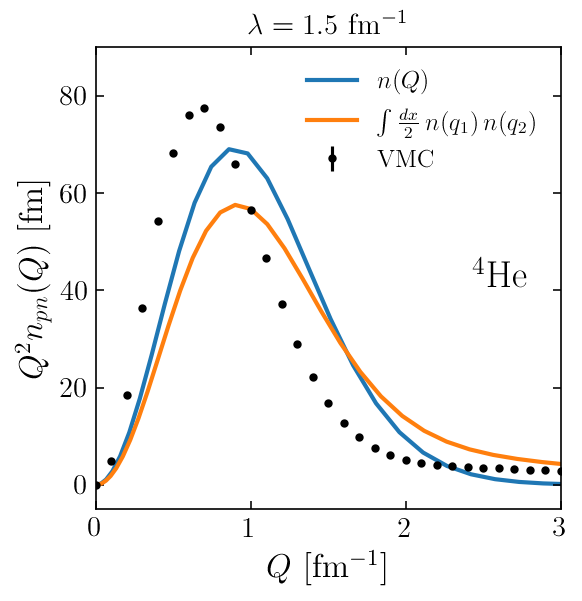

In [24]:
Q_array, n_array = pair_momentum_distribution_Q(
    'He4', 'pn', 6, 1.5, x_limits=(0.0,3.0), y_limits=(-5,90),
    y_scale='linear', show_vmc=True
)